In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

from shapkit_nbdev.shapley_values import ShapleyValues
from shapkit_nbdev.inspector import inspector
from shapkit_nbdev.monte_carlo_shapley import MonteCarloShapley
from shapkit_nbdev.sgd_shapley import SGDshapley

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset

In [2]:
df = pd.read_csv("/home/sgrah/Documents/xAI/sophia_summit/compas_dataset/compas.csv")
df.age = df.age.astype("int")
df.priors_count = df.priors_count.astype("int")
df.columns = ['gender', 'ethnicity', 'legal_status', 'custody_status', 'marital_status',
              'recidivism_probability', 'age', 'priors_crimes_count']
df = df[df.recidivism_probability.isin(['Low', 'High'])]
df.head(5)

,gender,ethnicity,legal_status,custody_status,marital_status,recidivism_probability,age,priors_crimes_count
0,Male,Caucasian,Pretrial,Jail Inmate,Married,Low,31,0
1,Male,African-American,Pretrial,Jail Inmate,Single,High,21,1
3,Female,African-American,Pretrial,Jail Inmate,Single,Low,30,0
4,Male,Hispanic,Pretrial,Jail Inmate,Single,High,32,20
5,Female,Caucasian,Pretrial,Jail Inmate,Single,Low,49,0


In [4]:
target_names = 'recidivism_probability'
columns = [col for col in df.columns if col != target_names]
X = df[columns].copy()
labels = df[target_names].copy()
y = np.where(labels == 'Low', 0, 1)
print("Classes: {0}".format(np.unique(labels)))
X.head(3)

Classes: ['High' 'Low']


,gender,ethnicity,legal_status,custody_status,marital_status,age,priors_crimes_count
0,Male,Caucasian,Pretrial,Jail Inmate,Married,31,0
1,Male,African-American,Pretrial,Jail Inmate,Single,21,1
3,Female,African-American,Pretrial,Jail Inmate,Single,30,0



# Train a ML model

In [5]:
cat_features = ['gender', 'ethnicity', 'legal_status', 'custody_status', 'marital_status']
cat_features_index = [i for i, col in enumerate(X.columns) if col in cat_features]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.33,
                                                  random_state=42)
test_data = catboost_pool = Pool(X_test, y_test,
                                 cat_features=cat_features_index)
val_data = catboost_pool = Pool(X_val, y_val,
                                cat_features=cat_features_index)

model = CatBoostClassifier(iterations=200,
                           depth=5,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=20)
# train the model
model.fit(X_train, y_train,
          cat_features=cat_features_index,
          eval_set=val_data)
# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
print("Test Accuracy: {0:.2}".format(np.mean(preds_class == y_test)))

0:	learn: 0.4642593	test: 0.4567796	best: 0.4567796 (0)	total: 89.5ms	remaining: 17.8s
20:	learn: 0.3708433	test: 0.3890843	best: 0.3890843 (20)	total: 263ms	remaining: 2.24s
40:	learn: 0.3393934	test: 0.3795197	best: 0.3793465 (36)	total: 413ms	remaining: 1.6s
60:	learn: 0.3238395	test: 0.3798016	best: 0.3765597 (54)	total: 540ms	remaining: 1.23s
80:	learn: 0.3088234	test: 0.3846077	best: 0.3765597 (54)	total: 667ms	remaining: 980ms
100:	learn: 0.3002132	test: 0.3852011	best: 0.3765597 (54)	total: 783ms	remaining: 767ms
120:	learn: 0.2900827	test: 0.3868944	best: 0.3765597 (54)	total: 1.01s	remaining: 661ms
140:	learn: 0.2783800	test: 0.3916980	best: 0.3765597 (54)	total: 1.17s	remaining: 488ms
160:	learn: 0.2689697	test: 0.3942314	best: 0.3765597 (54)	total: 1.31s	remaining: 317ms
180:	learn: 0.2609107	test: 0.3952044	best: 0.3765597 (54)	total: 1.42s	remaining: 150ms
199:	learn: 0.2514048	test: 0.3948909	best: 0.3765597 (54)	total: 1.54s	remaining: 0us

bestTest = 0.3765596588
bestI

# Define the game

In [91]:
d = X_train.shape[1]
n = 2**d - 2
d, n

(7, 126)

In [92]:
fc = lambda x: int(model.predict(x))

In [93]:
r_class, x_class = 0, 0
while x_class == r_class:
    idx_r, idx_x = np.random.choice(np.arange(len(X_test)), size=2, replace=False)
    r = X_test.iloc[idx_r,:]
    x = X_test.iloc[idx_x,:]
    r_class = fc(r.values)
    x_class = fc(x.values)
fc_class = lambda x: 1 if int(fc(x)) == int(x_class) else 0

In [94]:
print(r)
print()
print("Class Prediction for r: {0:.0f}".format(model.predict(r.values)))
print("Real class for r: {0:.0f}".format(y_test[idx_r]))

gender                             Male
ethnicity              African-American
legal_status                   Pretrial
custody_status              Jail Inmate
marital_status                 Divorced
age                                  32
priors_crimes_count                   1
Name: 2531, dtype: object

Class Prediction for r: 0
Real class for r: 0


In [95]:
print(x)
print()
print("Class Prediction for x: {0:.0f}".format(model.predict(x.values)))
print("Real class for x: {0:.0f}".format(y_test[idx_x]))

gender                              Male
ethnicity               African-American
legal_status                    Pretrial
custody_status               Jail Inmate
marital_status         Significant Other
age                                   30
priors_crimes_count                   11
Name: 17868, dtype: object

Class Prediction for x: 1
Real class for x: 1


# Exact Shapley Values

In [96]:
true_shap = ShapleyValues(x=x, fc=fc_class, r=r)

100%|██████████| 7/7 [00:00<00:00, 11.68it/s]


In [97]:
true_shap

gender                 0.000000
ethnicity              0.000000
legal_status           0.000000
custody_status         0.000000
marital_status         0.333333
age                   -0.166667
priors_crimes_count    0.833333
dtype: float64

# Approximation methods

## Monte Carlo 

In [98]:
mc_shap = MonteCarloShapley(x=x, fc=fc_class, r=r, n_iter=100)
mc_shap

100%|██████████| 100/100 [00:00<00:00, 161.67it/s]


gender                 0.00
ethnicity              0.00
legal_status           0.00
custody_status         0.00
marital_status         0.38
age                   -0.24
priors_crimes_count    0.86
dtype: float64

## SGD

In [99]:
sgd_est = SGDshapley(d, C=y.max())
sgd_shap = sgd_est.sgd(x=x, fc=fc_class, r=r, n_iter=1000, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 1000/1000 [00:01<00:00, 965.87it/s]


gender                 0.008110
ethnicity              0.042822
legal_status           0.026258
custody_status        -0.012271
marital_status         0.303875
age                   -0.143291
priors_crimes_count    0.774497
dtype: float64

# Comparison with several references 

In [115]:
pred_train = model.predict(X_train)
idx_ref = np.argwhere(pred_train != x_class).flatten()
pool_ref = X_train.iloc[idx_ref[:100]]
pool_ref.head(5)

,gender,ethnicity,legal_status,custody_status,marital_status,age,priors_crimes_count
609,Female,African-American,Pretrial,Pretrial Defendant,Single,25,2
11603,Female,Caucasian,Pretrial,Jail Inmate,Single,43,0
2979,Male,African-American,Pretrial,Jail Inmate,Single,39,1
7780,Male,African-American,Pretrial,Jail Inmate,Single,33,1
14335,Male,African-American,Pretrial,Jail Inmate,Single,34,2


In [116]:
n_ref = len(pool_ref)
x_attributes = [feature + " = " + str(val) for feature, val in x.iteritems()]
pool_shapley = pd.DataFrame(np.zeros((n_ref, d+1)), columns=["ref_pred"] + x_attributes)
for i in range(n_ref):
    r = pool_ref.iloc[i]
    ref_pred = fc_class(r.values)
    pool_shapley.iloc[i,0] = ref_pred
    true_shap = ShapleyValues(x=x, fc=fc_class, r=r)
    pool_shapley.iloc[i,1:] = true_shap.values

100%|██████████| 7/7 [00:00<00:00, 12.39it/s]


In [117]:
mean_pool_shap = pool_shapley.mean(axis=0)
mean_pool_shap

ref_pred                              0.000000
gender = Male                        -0.001167
ethnicity = African-American          0.047667
legal_status = Pretrial               0.004333
custody_status = Jail Inmate          0.018333
marital_status = Significant Other    0.090833
age = 30                              0.023167
priors_crimes_count = 11              0.816833
dtype: float64

In [118]:
np.sum(mean_pool_shap)

0.9999999999999996

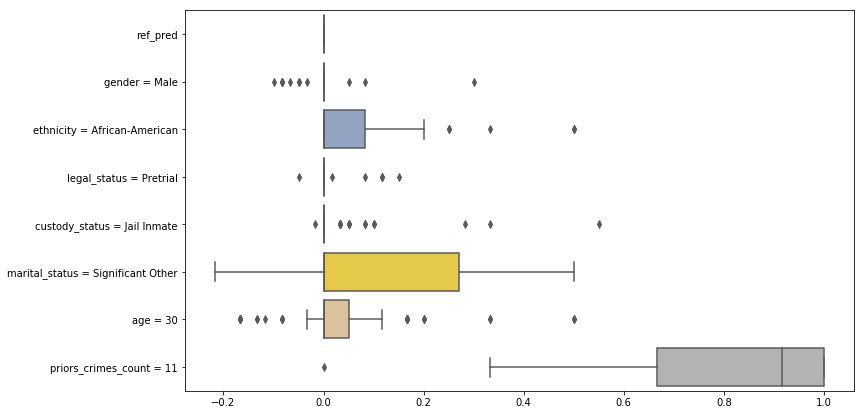

In [119]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=pool_shapley, orient="h", palette="Set2")
plt.show()